In [12]:
import sys
import time
import os
import stim
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import subprocess
from IPython.display import SVG, display
from pathlib import Path

# import chromobius

sys.path.insert(0, os.path.abspath('/hpc/home/garn195/NWQ-Sim/stabilizer/src'))

import noise_util as ns
import surface_code as sc
importlib.reload(ns)
import tomography_util as tm
importlib.reload(sc)
importlib.reload(ns)
importlib.reload(tm)

<module 'tomography_util' from '/hpc/home/garn195/NWQ-Sim/stabilizer/src/tomography_util.py'>

In [13]:
# Experiment Parameters
SHOTS = 10000000
BASE_ERROR = 0.001
DISTANCES = np.array([11, 7, 5, 3])
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([4*10**-7, 6*10**-7, 8*10**-7, 10**-6, 2*10**-6, 4*10**-6, 10**-5])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
compile_command = [
    "mpicxx",  # use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-DMPI_ENABLED",
    "-o",
    "noisy_code_sim",
    "noisy_code_sim.cpp"
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [ ]:
def run_single_distance_experiment(distance, tau_values, shots, base_error):
    """
    For a single code distance, sweep over tau_values and compute LERs for both Stim and C++ pipelines.
    Returns two lists [LER(tau_i)] for Stim and C++ aligned with tau_values.

    Now supports reading large (billions) of C++ shots via streaming MPI-IO output:
      * Binary bit-packed format (fmt=1) .bin using NWQSIM binary header (magic NWQBIN01)
      * Binary RAW format (fmt=2) 1 byte per measurement bit (simpler for debugging)
      * Legacy text format (.txt) still supported.
    """
    import struct

    print(f"\n=== Distance = {distance} ===")

    # Pre-create base circuit (structure doesn't depend on tau)
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=distance,
        distance=distance
    )

    # Ensure output folder exists
    out_dir = "./surface_code_qasm"
    os.makedirs(out_dir, exist_ok=True)

    stim_ler_list = []
    cpp_ler_list = []

    def iter_cpp_measurements(path, max_rows_target=None):
        """Yield boolean numpy arrays (chunk_rows, row_len) from C++ output.
        Auto-detect binary header and format flag.
        Binary header (64 bytes): magic, n_qubits, shots_total, row_len, fmt_flag (1=bit-packed,2=raw-bytes).
        For fmt=1 we unpack bits and return dtype=bool so stim treats them as full bit matrices (NOT bit-packed).
        For fmt=2 we read raw bytes (0/1) and cast to bool. Text mode parsed similarly.
        """
        binary = False
        with open(path, 'rb') as fpeek:
            head = fpeek.read(8)
            if head == b'NWQBIN01':
                binary = True
        if binary:
            with open(path, 'rb') as f:
                header = f.read(64)
                magic = header[:8]
                if magic != b'NWQBIN01':
                    raise ValueError('Bad magic in binary file')
                n_qubits = struct.unpack('<Q', header[8:16])[0]
                shots_total = struct.unpack('<Q', header[16:24])[0]
                row_len = struct.unpack('<Q', header[24:32])[0]
                fmt_flag = struct.unpack('<Q', header[32:40])[0]
                # stride in bytes per shot
                if fmt_flag == 1:  # bit-packed
                    stride = (row_len + 7)//8
                elif fmt_flag == 2:  # raw bytes
                    stride = row_len
                else:
                    raise ValueError(f'Unknown fmt_flag {fmt_flag}')
                # Decide chunk size
                try:
                    import psutil
                    avail = psutil.virtual_memory().available
                except Exception:
                    avail = 8 * 1024**3
                if max_rows_target is None:
                    headroom = 16
                    max_rows = max(1, int(min(shots_total, (avail//headroom)//max(1,stride), 5_000_000)))
                else:
                    max_rows = max_rows_target
                buf_bytes = stride * max_rows
                offset = 64
                while True:
                    with open(path, 'rb') as fb:
                        fb.seek(offset)
                        data = fb.read(buf_bytes)
                    if not data:
                        break
                    n_full = len(data)//stride
                    if n_full == 0:
                        break
                    if len(data) != n_full*stride:
                        data = data[:n_full*stride]
                    if fmt_flag == 1:
                        # bit-packed -> unpack then reshape
                        arr_u8 = np.frombuffer(data, dtype=np.uint8, count=n_full*stride)
                        bits = np.unpackbits(arr_u8)[:n_full*row_len]
                        yield bits.reshape(n_full, row_len).astype(bool, copy=False)
                    else:  # raw bytes
                        arr = np.frombuffer(data, dtype=np.uint8, count=n_full*stride)
                        arr = arr.reshape(n_full, row_len)
                        yield (arr != 0)
                    offset += n_full*stride
        else:
            # Text mode parsing (space separated 0/1)
            with open(path, 'r') as f:
                first_line = ''
                for ln in f:
                    ln = ln.strip()
                    if ln:
                        first_line = ln
                        break
            if not first_line:
                raise FileNotFoundError('Empty measurements file.')
            row_len = len(first_line.split())
            try:
                import psutil
                avail_bytes = psutil.virtual_memory().available
            except Exception:
                avail_bytes = 8 * 1024**3
            bytes_per_row = row_len
            headroom = 8
            max_rows = max(1, (avail_bytes // headroom) // max(1, bytes_per_row))
            max_rows = int(min(max_rows, shots, 5_000_000))
            buf = np.empty((max_rows, row_len), dtype=bool)
            r = 0
            def rows_iterator(p):
                with open(p, 'r') as f:
                    for ln in f:
                        ln = ln.strip()
                        if ln:
                            yield ln
            for ln in rows_iterator(path):
                arr = np.fromstring(ln, dtype=np.int8, sep=' ')
                if arr.size != row_len:
                    arr = np.resize(arr, row_len)
                buf[r, :] = (arr != 0)
                r += 1
                if r == max_rows:
                    yield buf[:r]
                    r = 0
            if r:
                yield buf[:r]

    for tau_i in tau_values:
        # Per-tau noise parameters (SCALARS)
        p_amp_i = 1 - np.exp(-tau_i / T1)
        p_phase_i = 1 - np.exp(-lam * tau_i)

        # 1) Build noise model and noisy circuit for this tau (Stim twirled model)
        model = ns.ErrorModel(circuit)
        model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
        model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        stim_circuit = model.generate_noisy_circuit()

        # Build STABSim model (with amplitude damping for M/RESET) using SAME scalar values
        model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase_i}, {p_amp_i})')
        model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase_i}, {p_amp_i})')
        stab_circuit = model.generate_noisy_circuit()

        # 2) Stim simulation
        stim_sampler = stim_circuit.compile_detector_sampler()
        start_time = time.perf_counter()
        stim_det_samples, stim_obs_flips = stim_sampler.sample(shots, separate_observables=True, bit_packed=False)
        stim_time = time.perf_counter() - start_time

        dem = stim_circuit.detector_error_model(decompose_errors=True)
        matching = pymatching.Matching.from_detector_error_model(dem)

        stim_errors = 0
        stim_post_selected = 0
        for i in range(shots):
            stim_post_selected += 1
            prediction = matching.decode(stim_det_samples[i])
            if prediction[0] != stim_obs_flips[i][0]:
                stim_errors += 1
        stim_ler = stim_errors / stim_post_selected if stim_post_selected > 0 else 0.0
        stim_ler_list.append(stim_ler)
        print(f"tau/T1={tau_i/T1:.3f} | Stim LER: {stim_ler:.4e} (time {stim_time:.3f}s)")

        cpp_ler = 0.0
        if stim_ler == 0.0:
            cpp_ler_list.append(cpp_ler)
            print("Stim LER was 0. Skipping c++ analysis.")
            continue
        else:
            # 3) C++ simulation path for same tau
            qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
            qasm_output = ns.inject_amplitude_damp(qasm_output, model)
            if "damp(" not in qasm_output:
                print(f"[warn] No 'damp' found in QASM for tau/T1={tau_i/T1:.3f}. Check AMPLITUDE_DAMP args.")

            out_dir = "./surface_code_qasm"
            os.makedirs(out_dir, exist_ok=True)
            tmp_dir = "/dev/shm/surface_code_tmp" if os.path.isdir("/dev/shm") else out_dir
            os.makedirs(tmp_dir, exist_ok=True)

            qasm_file_path = os.path.join(out_dir, f"surface_code_d{distance}_tau{tau_i:.2e}.qasm")
            # Use RAW (1 byte per bit) for simple parsing & debugging
            cpp_output_path = os.path.join(tmp_dir, f"measurements_d{distance}_tau{tau_i:.2e}.bin")
            with open(qasm_file_path, "w") as f:
                f.write(qasm_output)

            num_qubits = stab_circuit.num_qubits
            run_command = [
                "mpirun", "-np", str(int(os.cpu_count()*.8)),
                "./noisy_code_sim", str(num_qubits), str(shots), qasm_file_path, cpp_output_path
            ]
            run_env = dict(os.environ)
            run_env['NWQSIM_OUTPUT_FORMAT'] = 'raw'  # ensure RAW format (fmt=2)
            result = subprocess.run(run_command, capture_output=True, text=True, env=run_env)

            cpp_time = 0.0
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass

            # Streaming decode (binary or text)
            try:
                m2d_converter = stab_circuit.compile_m2d_converter()
                cpp_errors = 0
                cpp_post_selected = 0

                for chunk in iter_cpp_measurements(cpp_output_path):
                    det, obs = m2d_converter.convert(measurements=chunk, separate_observables=True)
                    for i in range(len(det)):
                        cpp_post_selected += 1
                        if matching.decode(det[i])[0] != obs[i][0]:
                            cpp_errors += 1
                cpp_ler = cpp_errors / cpp_post_selected if cpp_post_selected > 0 else 0.0
            except FileNotFoundError:
                print("C++ output file not found. Skipping analysis.")
                cpp_ler = 0.0
            except Exception as e:
                print(f"[error] C++ decode failure: {e}")
                cpp_ler = 0.0
            finally:
                try:
                    os.remove(cpp_output_path)
                except OSError:
                    pass

            cpp_ler_list.append(cpp_ler)
            print(f"tau/T1={tau_i/T1:.3f} | C++  LER: {cpp_ler:.4e} (time {cpp_time:.3f}s)")
    return stim_ler_list, cpp_ler_list

# --- Sweep over distances and tau ---
stim_results = {}  # distance -> [LER(tau_i)]
cpp_results = {}

for d in DISTANCES:
    stim_lers, cpp_lers = run_single_distance_experiment(d, tau, SHOTS, BASE_ERROR)
    stim_results[d] = stim_lers
    cpp_results[d] = cpp_lers

print("\n=== Sweep Complete ===")
print({"stim": {int(k): v for k, v in stim_results.items()}})
print({"cpp": {int(k): v for k, v in cpp_results.items()}})


=== Distance = 11 ===


In [ ]:
import json, time
from pathlib import Path

results_dir = Path("surface_results")
results_dir.mkdir(parents=True, exist_ok=True)

distances_str = "x".join(map(str, map(int, np.asarray(DISTANCES).tolist())))
timestamp = time.strftime("%Y%m%d-%H%M%S")
results_file = results_dir / f"surfacecode_LER_{distances_str}_shots{int(SHOTS)}_{timestamp}.json"

payload = {
    "shots": int(SHOTS),
    "T1": float(T1),
    "T2": float(T2),
    "tau": list(map(float, np.asarray(tau, dtype=float))),
    "distances": list(map(int, np.asarray(DISTANCES).tolist())),
    "stim": {str(int(k)): list(map(float, v)) for k, v in stim_results.items()},
    "cpp":  {str(int(k)): list(map(float, v)) for k, v in cpp_results.items()},
}

with open(results_file, "w") as f:
    json.dump(payload, f, indent=2)

print(f"Saved results to: {results_file}")

Saved results to: surface_results/surfacecode_LER_11x7x5x3_shots10000000_20250913-223735.json


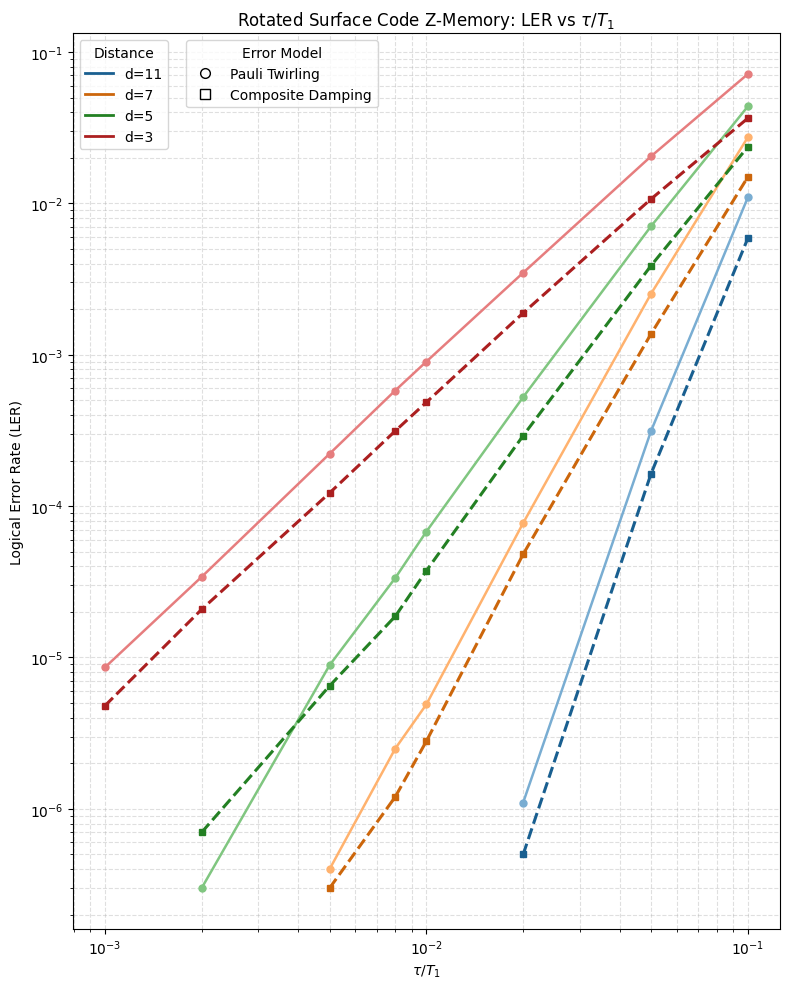

In [ ]:
# --- Plotting Results ---
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import colorsys

plt.figure(figsize=(8, 10))

x_vals_all = np.asarray(tau / T1, dtype=float)

# Helpers to lighten/darken base colors
import numpy as np

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')

# Plot paired curves per distance using related colors
color_handles = []  # for the distance legend (dark colors only)
for i, d in enumerate(DISTANCES):
    if d != 13:
        base = cmap(i % cmap.N)
        stim_color = lighten(base, 0.6)
        cpp_color = darken(base, 0.8)

        y_stim_all = np.asarray(stim_results[d], dtype=float)
        y_cpp_all  = np.asarray(cpp_results[d], dtype=float)

        # Filter where C++ LER is not greater than Stim LER
        filter_mask = y_cpp_all <= y_stim_all
        x_vals = x_vals_all[filter_mask]
        y_stim = y_stim_all[filter_mask]
        y_cpp = y_cpp_all[filter_mask]

        mask_stim = y_stim > 0
        mask_cpp  = y_cpp  > 0

        plotted_any = False
        if mask_stim.any():
            plt.plot(
                x_vals[mask_stim], y_stim[mask_stim],
                marker='o', linestyle='-', linewidth=1.8, markersize=5,
                color=stim_color, label=f'Pauli Twirling d={d}'
            )
            plotted_any = True

        if mask_cpp.any():
            plt.plot(
                x_vals[mask_cpp], y_cpp[mask_cpp],
                marker='s', linestyle='--', linewidth=2.2, markersize=5,
                color=cpp_color, label=f'Composite Damping d={d}'
            )
            plotted_any = True

        # Add a single handle per distance using the dark color
        if plotted_any:
            color_handles.append(Line2D([0], [0], color=cpp_color, lw=2, label=f'd={d}'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Pauli Twirling'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Composite Damping'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model', loc='upper left', bbox_to_anchor=(.15, 1))

# Legend 2: colors for distance (dark colors only)
ax.add_artist(shape_legend)  # keep the first legend when adding the second
ax.legend(handles=color_handles, title='Distance', loc='upper left', ncol=1)

plt.tight_layout()
plt.savefig(f'figures/surfacecode_LER{SHOTS}.pdf', dpi=500, bbox_inches='tight')
plt.show()

Loading: surface_results/surfacecode_LER_11x7x5x3_shots5000000_20250913-025456.json


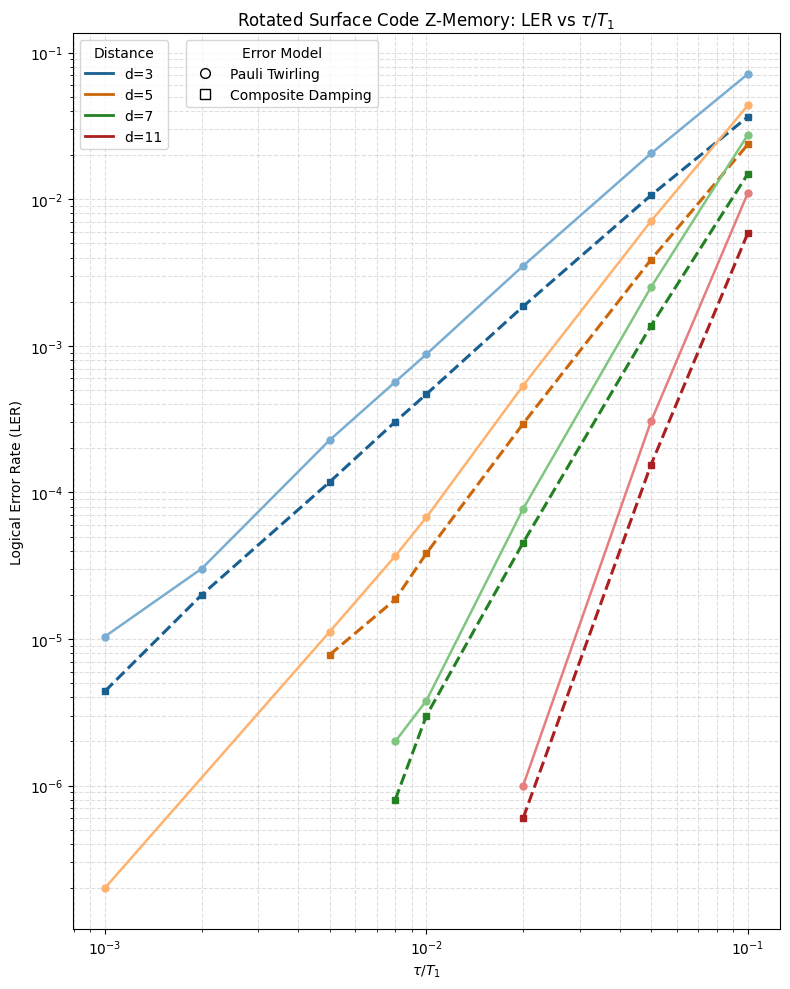

In [ ]:
# Regenerate plot from saved JSON results
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from pathlib import Path

# Set to the path printed by the save cell (or pick latest)
results_dir = Path("surface_results")
# results_file = results_dir / "surfacecode_LER_13_shots10000_YYYYMMDD-HHMMSS.json"
# Auto-pick latest matching file if desired:
candidates = sorted(results_dir.glob("surfacecode_LER_*_shots*.json"))
if not candidates:
    raise FileNotFoundError("No saved results found in ./results")
results_file = candidates[-1]
print(f"Loading: {results_file}")

with open(results_file, "r") as f:
    data = json.load(f)

SHOTS = int(data["shots"])
T1 = float(data["T1"])
T2 = float(data["T2"])
tau = np.asarray(data["tau"], dtype=float)
DISTANCES = np.asarray(data["distances"], dtype=int)
stim_results = {int(k): np.asarray(v, dtype=float) for k, v in data["stim"].items()}
cpp_results  = {int(k): np.asarray(v, dtype=float) for k, v in data["cpp"].items()}

plt.figure(figsize=(8, 10))
x_vals_all = np.asarray(tau / T1, dtype=float)

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')
color_handles = []

for i, d in enumerate(sorted(stim_results.keys())):
    base = cmap(i % cmap.N)
    stim_color = lighten(base, 0.6)
    cpp_color  = darken(base, 0.8)

    y_stim_all = np.asarray(stim_results[d], dtype=float)
    y_cpp_all  = np.asarray(cpp_results.get(d, np.zeros_like(y_stim_all)), dtype=float)
    
    # Filter where C++ LER is not greater than Stim LER
    filter_mask = y_cpp_all <= y_stim_all
    x_vals = x_vals_all[filter_mask]
    y_stim = y_stim_all[filter_mask]
    y_cpp = y_cpp_all[filter_mask]

    mask_stim = y_stim > 0
    mask_cpp  = y_cpp  > 0

    plotted_any = False
    if mask_stim.any():
        plt.plot(
            x_vals[mask_stim], y_stim[mask_stim],
            marker='o', linestyle='-', linewidth=1.8, markersize=5,
            color=stim_color, label=f'Pauli Twirling d={d}'
        )
        plotted_any = True

    if mask_cpp.any():
        plt.plot(
            x_vals[mask_cpp], y_cpp[mask_cpp],
            marker='s', linestyle='--', linewidth=2.2, markersize=5,
            color=cpp_color, label=f'Composite Damping d={d}'
        )
        plotted_any = True

    if plotted_any:
        color_handles.append(Line2D([0], [0], color=cpp_color, lw=2, label=f'd={d}'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Pauli Twirling'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Composite Damping'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model',
                         loc='upper left', bbox_to_anchor=(.15, 1))
ax.add_artist(shape_legend)

# Legend 2: distance colors (dark only)
if color_handles:
    ax.legend(handles=color_handles, title='Distance', loc='upper left', ncol=1)

# Save figure
Path("figures").mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(f'figures/surfacecode_LER{SHOTS}_from_saved.pdf', dpi=500, bbox_inches='tight')
plt.show()